# Figure 5 - Reaction mechanism determination

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize

import ast

import pymc3 as pm
import arviz as az
import theano.tensor as tt

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-11 12:08:58

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.2.0

pymc3     : 3.11.4
seaborn   : 0.11.2
pandas    : 1.2.4
theano    : 1.1.2
networkx  : 2.6.3
numpy     : 1.20.3
matplotlib: 3.4.3
scipy     : 1.6.3
arviz     : 0.11.4



## Helper functions for plotting

In [2]:
def savefig(name):
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

XSIZE = 7.0 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def generate_figure(n_col, n_row):
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs


## Data loading

In [3]:
experiments = pd.read_csv(f"../data/kinetic_studies.csv").query(
    f'enzyme == "G6PDH"'
)
data = []
for t in experiments.itertuples():
    df = pd.read_csv(f"../data/{t.data_path}")
    df = df.assign(
        kf=t.flowrate / (60 * t.volume),
        G6PDH=t.enzyme_concentration,
        code=t.experiment_code,
    )
    data.append(df)

data = pd.concat(data).reset_index(drop=True)

exp_idx, exp_coords = data.code.factorize(sort=True)
data = data.assign(
    NAD_obs=data.NAD_in - data.NADH_obs,
    G6P_obs=data.G6P_in - data.NADH_obs,
    G6PdL_obs=data.NADH_obs,
    exp_idx = exp_idx
)

## Creation of models

In [4]:
def compile_model_0(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_0:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')

        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_0

def compile_model_1(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_1:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)
        KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')


        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_1

def compile_model_2(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_2:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)
        KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')

        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD+ NADH/KI_NADH)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_2

def compile_model_3(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_3:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)
        KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')


        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P + NADH/KI_NADH)*(1+NAD/K_NAD)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_3

def compile_model_4(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_4:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)
        KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')

        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P + NADH/KI_NADH)*(1+NAD/K_NAD+ NADH/KI_NADH)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_4

def compile_model_5(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_5:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)
        KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')

        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)*(1+ NADH/KI_NADH)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_5

def compile_model_6(data):
    exp_idx, exp_coords = data.code.factorize(sort=True)
    coords = {"exp": exp_coords}

    with pm.Model(coords=coords) as model_6:
        k_cat = pm.Uniform("k_cat", 0, 500)
        K_G6P = pm.Uniform("K_G6P", 1, 4000)
        K_NAD = pm.Uniform("K_NAD", 1, 2000)
        KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

        sigma = pm.Exponential("sigma", 0.2, dims='exp')

        G6PDH = pm.Data("G6PDH", data.G6PDH.values)
        NADH = pm.Data("NADH_obs", data.NADH_obs.values)
        NAD = pm.Data("NAD_obs", data.NAD_obs.values)

        G6P = pm.Data("G6P_obs", data.G6P_obs.values)
        G6PdL = pm.Data("G6PdL_obs", data.G6PdL_obs.values)

        G6P_in = pm.Data("G6P_in", data.G6P_in.values)
        NAD_in = pm.Data("NAD_in", data.NAD_in.values)
        kf = pm.Data("kf", data.kf.values)

        exp_idx = pm.Data("exp_idx", data.exp_idx.values)

        NADH_obs = pm.Normal("NADH", 
                    mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*KI_NADH*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)),
                    sigma=sigma[exp_idx],
                    observed= NADH
                    )
    return model_6

## Model sampling

In [5]:
sample_kwargs = {"draws": 1000, "tune": 1000, "chains": 4, 'target_accept': 0.92, 'progressbar': True, 'return_inferencedata': True}

In [6]:
model_0 = compile_model_0(data)
model_1 = compile_model_1(data)
model_2 = compile_model_2(data)
model_3 = compile_model_3(data)
model_4 = compile_model_4(data)
model_5 = compile_model_5(data)
model_6 = compile_model_6(data)


In [7]:
with model_0:
    idata_0 = pm.sample(**sample_kwargs)
    idata_0.to_netcdf("idata/idata_H0.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [8]:
with model_1:
    idata_1 = pm.sample(**sample_kwargs)
    idata_1.to_netcdf("idata/idata_H1.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [9]:
with model_2:
    idata_2 = pm.sample(**sample_kwargs)
    idata_2.to_netcdf("idata/idata_H2.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [10]:
with model_3:
    idata_3 = pm.sample(**sample_kwargs)
    idata_3.to_netcdf("idata/idata_H3.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [11]:
with model_4:
    idata_4 = pm.sample(**sample_kwargs)
    idata_4.to_netcdf("idata/idata_H4.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
with model_5:
    idata_5 = pm.sample(**sample_kwargs)
    idata_5.to_netcdf("idata/idata_H5.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
with model_6:
    idata_6 = pm.sample(**sample_kwargs)
    idata_6.to_netcdf("idata/idata_H6.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [14]:
idata_0 = az.from_netcdf("idata/idata_H0.nc")
idata_1 = az.from_netcdf("idata/idata_H1.nc")
idata_2 = az.from_netcdf("idata/idata_H2.nc")
idata_3 = az.from_netcdf("idata/idata_H3.nc")
idata_4 = az.from_netcdf("idata/idata_H4.nc")
idata_5 = az.from_netcdf("idata/idata_H5.nc")
idata_6 = az.from_netcdf("idata/idata_H6.nc")


# Diagnostics

In [15]:
def sampling_stats(idata: az.InferenceData):
    return pd.DataFrame({'Chains': int(idata.sample_stats.coords['chain'].size), 
    'Tuning steps': int(idata.sample_stats.tuning_steps), 
    'Draws': int(idata.sample_stats.coords['draw'].size),
    'Mean acceptance rate': round(idata.sample_stats.acceptance_rate.mean().values[()], 3),
    'Divergences': int(idata.sample_stats.diverging.sum().values[()]), 
}, index=[0])


In [44]:
hypothesis = {'H_0': idata_0,
    'H_1': idata_2,
    'H_2': idata_3,
    'H_3': idata_1,
    'H_4': idata_5
}

for k, v in hypothesis.items():
    filename = f"diagnostics/mechanisms_{k}_sampling.md"
    table_str = sampling_stats(v).to_markdown()
    table_str += f'\nTable: Sampling statistics for manuscript Figure 5, Hypothesis {k[-1]}'
    with open(filename, 'wt') as f:
        f.write(table_str)

    filename = f"diagnostics/mechanisms_{k}.md"
    table_str = az.summary(v, kind='diagnostics').round(2).to_markdown()
    table_str += f'\nTable: Sampling diagnostics for manuscript Figure 5, Hypothesis {k[-1]}'
    with open(filename, 'wt') as f:
        f.write(table_str)

    az.plot_trace(v, filter_vars='like', figsize=(7, 1.25*5))
    plt.tight_layout()
    savefig(f"mechanisms_{k}_traces")
    plt.close()

## Posterior predictive sampling

In [17]:
with model_0:
    post_pred_0 = pm.sample_posterior_predictive(idata_0, var_names=['NADH'] )
with model_1:
    post_pred_1 = pm.sample_posterior_predictive(idata_1, var_names=['NADH'] )
with model_2:
    post_pred_2 = pm.sample_posterior_predictive(idata_2, var_names=['NADH'] )
with model_3:
    post_pred_3 = pm.sample_posterior_predictive(idata_3, var_names=['NADH'] )
with model_4:
    post_pred_4 = pm.sample_posterior_predictive(idata_4, var_names=['NADH'] )
with model_5:
    post_pred_5 = pm.sample_posterior_predictive(idata_5, var_names=['NADH'] )

# Analysis

In [42]:
dataset_dict = {
    r'$H_0$': idata_0,
    r'$H_1$': idata_2,
    r'$H_2$': idata_3,
    r'$H_3$': idata_1,
    r'$H_4$': idata_5
}

In [43]:
az.compare(dataset_dict, ic='loo', method='stacking')

/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
$H_4$,0,-254.491139,8.388564,0.000000,5.553834e-01,13.727017,0.000000,False,log
$H_3$,1,-256.594494,8.966612,2.103355,1.044037e-15,13.982137,1.123916,False,log
$H_1$,2,-259.502770,9.177433,5.011631,1.570332e-15,14.560152,3.079663,False,log
$H_2$,3,-263.954309,9.565849,9.463170,0.000000e+00,13.770358,3.548819,False,log
$H_0$,4,-272.064667,10.149979,17.573528,4.446166e-01,23.296089,15.553712,True,log


# Exact LOO comparisons

In [33]:
def select_observations(data, idx):
    return data.drop(idx), data.iloc[idx]

class PyMC3LinRegWrapper(az.SamplingWrapper):
    def __init__(self, data, data_vars, model, **kwargs):
        self.data = data
        self.data_vars = data_vars

        __selected_data, _ = self.sel_observations([0]) # Pre-compile model with LOO corrected shape
        self.pymc3_model = model(__selected_data)
        
        super(PyMC3LinRegWrapper, self).__init__(model=model, **kwargs)

    def sample(self, modified_observed_data):
        with self.pymc3_model:
            pm.set_data(
                modified_observed_data[self.data_vars]
            )
            trace = pm.sample(
                **(self.sample_kwargs | { 'return_inferencedata': False}), 
                idata_kwargs={"log_likelihood": False}
            )
        return trace
    
    def get_inference_data(self, trace):
        idata = az.from_pymc3(trace, model=self.pymc3_model, **self.idata_kwargs)
        idata.pymc3_trace = trace
        return idata
        
    def log_likelihood__i(self, excluded_observed_data, idata__i):
        with self.pymc3_model:
            pm.set_data(excluded_observed_data[self.data_vars])
        log_lik__i = az.from_pymc3(idata__i.pymc3_trace, model=self.pymc3_model, log_likelihood=True).log_likelihood["NADH"]
        return log_lik__i
        
    def sel_observations(self, idx):
        return select_observations(self.data, idx)

In [34]:
def custom_compare(dataset_dict, original_data, data_vars, sample_kwargs, ic='loo', method="stacking", b_samples=1000, alpha=1, seed=None, scale=None):
    """ Adapted from the arviz.compare function, 
    to perform exact LOO for observations where the PSIS-LOO Pareto shape exceeds 0.5.
    Only the loo information criterion, with stacking comparison method is implemented.
    """
    names = list(dataset_dict.keys())
    scale_value = 1
    ascending = False

    ic_func = az.loo
    df_comp = pd.DataFrame(
            index=names,
            columns=[
                "rank",
                "loo",
                "p_loo",
                "d_loo",
                "weight",
                "se",
                "dse",
                "warning",
                "loo_scale",
                "n_eloo"
            ],
            dtype=np.float64,
        )
    scale_col = "loo_scale"

    ic_se = f"{ic}_se"
    p_ic = f"p_{ic}"
    ic_i = f"{ic}_i"

    ics = pd.DataFrame()
    names = []
    n_eloos = []
    for name, (dataset, model_compiler) in dataset_dict.items():
        names.append(name)

        loo_orig = ic_func(dataset, pointwise=True, scale=scale)
        n_eloos.append((loo_orig.pareto_k > 0.5).sum().values)
        pymc3_wrapper = PyMC3LinRegWrapper(
            model=model_compiler, data=original_data, 
            data_vars=data_vars,
            sample_kwargs=sample_kwargs
        )

        ics = ics.append([az.reloo(pymc3_wrapper, loo_orig=loo_orig, k_thresh=0.5)])
    ics.index = names
    ics.sort_values(by=ic, inplace=True, ascending=ascending)
    ics[ic_i] = ics[ic_i].apply(lambda x: x.values.flatten())
    ics = ics.assign(n_eloo=n_eloos)

    from arviz.stats.stats import _ic_matrix
    from scipy.optimize import minimize
    if method.lower() == "stacking":
        rows, cols, ic_i_val = _ic_matrix(ics, ic_i)
        exp_ic_i = np.exp(ic_i_val / scale_value)
        km1 = cols - 1

        def w_fuller(weights):
            return np.concatenate((weights, [max(1.0 - np.sum(weights), 0.0)]))

        def log_score(weights):
            w_full = w_fuller(weights)
            score = 0.0
            for i in range(rows):
                score += np.log(np.dot(exp_ic_i[i], w_full))
            return -score

        def gradient(weights):
            w_full = w_fuller(weights)
            grad = np.zeros(km1)
            for k in range(km1):
                for i in range(rows):
                    grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.dot(exp_ic_i[i], w_full)
            return -grad

        theta = np.full(km1, 1.0 / cols)
        bounds = [(0.0, 1.0) for _ in range(km1)]
        constraints = [
            {"type": "ineq", "fun": lambda x: -np.sum(x) + 1.0},
            {"type": "ineq", "fun": np.sum},
        ]

        weights = minimize(
            fun=log_score, x0=theta, jac=gradient, bounds=bounds, constraints=constraints
        )

        weights = w_fuller(weights["x"])
        ses = ics[ic_se]
    if np.any(weights):
        min_ic_i_val = ics[ic_i].iloc[0]
        for idx, val in enumerate(ics.index):
            res = ics.loc[val]
            if scale_value < 0:
                diff = res[ic_i] - min_ic_i_val
            else:
                diff = min_ic_i_val - res[ic_i]
            d_ic = np.sum(diff)
            d_std_err = np.sqrt(len(diff) * np.var(diff))
            std_err = ses.loc[val]
            weight = weights[idx]
            df_comp.at[val] = (
                idx,
                res[ic],
                res[p_ic],
                d_ic,
                weight,
                std_err,
                d_std_err,
                res["warning"],
                res[scale_col],
                res['n_eloo']
            )

    df_comp["rank"] = df_comp["rank"].astype(int)
    df_comp["warning"] = df_comp["warning"].astype(bool)
    df_comp["n_eloo"] = df_comp["n_eloo"].astype(int)

    return df_comp.sort_values(by=ic, ascending=ascending)

In [35]:
data_vars = ['G6PDH','NADH_obs','NAD_obs','G6P_obs','G6PdL_obs','G6P_in','NAD_in','kf', 'exp_idx']

dataset_dict = {
    r'$H_0$': (idata_0, compile_model_0),
    r'$H_1$': (idata_2, compile_model_2),
    r'$H_2$': (idata_3, compile_model_3),
    r'$H_3$': (idata_1, compile_model_1),
    r'$H_4$': (idata_5, compile_model_5)
}

model_comparisons = custom_compare(dataset_dict, original_data=data, data_vars=data_vars, sample_kwargs=sample_kwargs)

/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home/mathieu/anaconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [36]:
model_comparisons

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,n_eloo
$H_4$,0,-254.654118,8.551543,0.000000,5.553750e-01,13.776106,0.000000,False,log,3
$H_3$,1,-256.644187,9.016305,1.990069,0.000000e+00,13.999396,1.069567,False,log,1
$H_1$,2,-259.613002,9.287664,4.958884,1.051424e-14,14.596900,3.074485,False,log,3
$H_2$,3,-264.182229,9.793769,9.528111,0.000000e+00,13.854594,3.573456,False,log,2
$H_0$,4,-271.882225,9.967537,17.228107,4.446250e-01,23.198761,15.373005,True,log,3


In [37]:
filename = f"diagnostics/mechanisms_loo_comparison.md"
table_str = model_comparisons.to_markdown()
table_str += f'\nTable: Mechanism comparison diagnostics for PSIS-LOO cross-validation, with exact LOO performed for observations where the PSIS-LOO approximation is invalid.'
with open(filename, 'wt') as f:
    f.write(table_str)

## Creation of figure

In [39]:
posterior_0 = idata_0.to_dataframe(['posterior'], include_coords=False)
posterior_1 = idata_1.to_dataframe(['posterior'], include_coords=False)
posterior_2 = idata_2.to_dataframe(['posterior'], include_coords=False)
posterior_3 = idata_3.to_dataframe(['posterior'], include_coords=False)
posterior_4 = idata_4.to_dataframe(['posterior'], include_coords=False)
posterior_5 = idata_5.to_dataframe(['posterior'], include_coords=False)

posteriors = [posterior_0,posterior_2,posterior_3, posterior_1,posterior_5]

'KI_NADH'


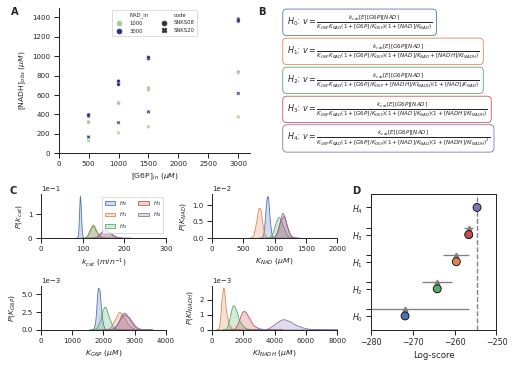

In [40]:
fig = plt.figure(figsize=(XSIZE, YSIZE), constrained_layout=True)
gs0 = fig.add_gridspec(2, 1)

gs = gs0[0].subgridspec(1,2)

ax_1 = fig.add_subplot(gs[0])

sns.scatterplot(ax=ax_1, data=data, x='G6P_in', y='NADH_obs', hue="NAD_in", palette='crest', style='code', markers=True, s=12)
ax_1.set_xlim(0, 3200)
ax_1.set_ylim(0, 1500)
ax_1.set_xlabel(r"$[$G6P$]_{in}~(\mu M)$")
ax_1.set_ylabel(r"$[$NADH$]_{obs}~(\mu M)$")
ax_1.legend(loc='upper center', fontsize='x-small', ncol=2)

ax_3 = fig.add_subplot(gs[1])
ax_3.axis('off')

ax_3.text(x=-0.15, y=0.9, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C0', pad=0.5), 
            s=r"$H_0$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})}$")
ax_3.text(x=-0.15, y=0.7, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C1', pad=0.5), 
            s=r"$H_1$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD}+[NADH]/KI_{NADH})}$")
ax_3.text(x=-0.15, y=0.5, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C2', pad=0.5), 
            s=r"$H_2$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P}+[NADH]/KI_{NADH})(1+[NAD]/K_{NAD})}$")
ax_3.text(x=-0.15, y=0.3, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C3', pad=0.5), 
            s=r"$H_3$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})(1+ [NADH]/KI_{NADH})}$")
ax_3.text(x=-0.15, y=0.1, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C4', pad=0.5), 
            s=r"$H_4$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})(1+ [NADH]/KI_{NADH})^2}$")

ax_1.text(-0.25, 0.95, 'A', transform=ax_1.transAxes, weight="bold", size=10)
ax_3.text(-0.3, 0.95, 'B', transform=ax_3.transAxes, weight="bold", size=10)


gs = gs0[1].subgridspec(2,3)
ax_4 = fig.add_subplot(gs[0,0])
ax_5 = fig.add_subplot(gs[1,0])
ax_6 = fig.add_subplot(gs[0,1])
ax_7 = fig.add_subplot(gs[1,1])

ax_4.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_5.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_6.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_7.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
for i, post in enumerate(posteriors):
    sns.kdeplot(post['k_cat'], ax=ax_4, fill=True, color=f'C{i}', label=r"$H_{}$".format(i))
ax_4.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax_4.set_ylabel(r"$P(k_{cat})$")
ax_4.set_xlim(0, 300)
ax_4.legend(loc='upper right', ncol=2, markerscale=0.5, fontsize='x-small', title_fontsize='small')

for i, post in enumerate(posteriors):
    sns.kdeplot(post['K_G6P'], ax=ax_5, fill=True, color=f'C{i}')
ax_5.set_xlabel(r"$K_{G6P}~(\mu M)$")
ax_5.set_ylabel(r"$P(K_{G6P})$")
ax_5.set_xlim(0, 4000)

for i, post in enumerate(posteriors):
    sns.kdeplot(post['K_NAD'], ax=ax_6, fill=True, color=f'C{i}')
ax_6.set_xlabel(r"$K_{NAD}~(\mu M)$")
ax_6.set_ylabel(r"$P(K_{NAD})$")
ax_6.set_xlim(0, 2000)

for i, post in enumerate(posteriors):
    try:
        sns.kdeplot(post['KI_NADH'], ax=ax_7, fill=True, color=f'C{i}')
    except KeyError as e:
        print(e)
ax_7.set_xlabel(r"$KI_{NADH}~(\mu M)$")
ax_7.set_ylabel(r"$P(KI_{NADH})$")
ax_7.set_xlim(0, 8000)

sns.despine()

ax_8 = fig.add_subplot(gs[:, 2])

# model_comparison = az.compare({
#     r'$H_0$': idata_0,
#     r'$H_1$': idata_2,
#     r'$H_2$': idata_3,
#     r'$H_3$': idata_1,
#     r'$H_4$': idata_5
# }, ic='loo', method='stacking')
ax_8 = az.plot_compare(model_comparisons, ax=ax_8, insample_dev=False, plot_standard_error=False)
ax_8.scatter(model_comparisons["loo"], ax_8.get_yticks()[::2], c=[ "C4", "C3", "C1","C2","C0"], s=64, ec='black', zorder=10)
ax_8.set_xlabel("Log-score")
ax_8.set_xlim(-280, -250)
ax_4.text(-0.25, 1.0, 'C', transform=ax_4.transAxes, weight="bold", size=10)
ax_8.text(-0.15, 1.0, 'D', transform=ax_8.transAxes, weight="bold", size=10)

savefig('fig5_mechanisms')
plt.show()

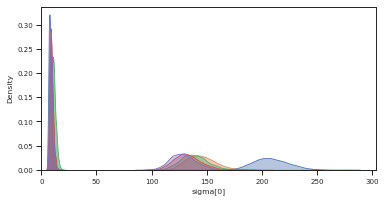

In [41]:
fig, ax = plt.subplots(figsize=(6,3))

for i, post in enumerate(posteriors):
    try:
        sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}', alpha=0.4)
        sns.kdeplot(post['sigma[1]'], ax=ax, fill=True, color=f'C{i}', alpha=0.6)
        # sns.kdeplot(post['sigma[2]'], ax=ax, fill=True, color=f'C{i}', alpha=0.8)
    except KeyError as e:
        print(e)

ax.set_xlim(0)
plt.show()